## What is XGBoost?

**XGBoost** (Extreme Gradient Boosting) is a scalable and efficient implementation of gradient boosting developed by Tianqi Chen and Carlos Guestrin in 2016. It has become one of the most popular machine learning algorithms for structured/tabular data, widely used in Kaggle competitions and production environments.

Compared to vanilla Gradient Boosting, XGBoost includes additional system-level and algorithmic optimizations such as:

- Regularization (to reduce overfitting)
- Tree pruning
- Parallelized tree construction
- Missing value handling
- Out-of-core computation for large datasets

## XGBoost Intuition

XGBoost extends vanilla gradient boosting with:

- **Regularization**: Penalizes complex models via L1/L2 terms in the loss function.
- **Second-order optimization**: Uses both gradients and hessians for faster convergence and more accurate splits.
- **Split constraints**: Prevents splits with insufficient gain (via `gamma`) during tree growth, avoiding the need for post-pruning.


## How XGBoost Works (Regression Example)

XGBoost minimizes the following **regularized objective** at each boosting round $t$:

$$
\mathcal{L}^{(t)} = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t-1)} + f_t(x_i)) + \Omega(f_t)
$$

Where:
- $l$ is a differentiable convex loss function (e.g., squared error)
- $f_t$ is the prediction function at iteration $t$ (a tree)
- $\Omega(f_t) = \gamma T + \frac{1}{2} \lambda \sum w_j^2$ is the regularization term (penalizes the number of leaves $T$ and leaf weights $w_j$)


To simplify optimization, XGBoost applies a **second-order Taylor approximation** of the loss function:

$$
\mathcal{L}^{(t)} \approx \sum_{i=1}^n \left[ g_i f_t(x_i) + \frac{1}{2} h_i f_t(x_i)^2 \right] + \Omega(f_t)
$$

Where:
- $g_i = \frac{\partial l(y_i, \hat{y}_i)}{\partial \hat{y}_i}$ is the first-order derivative (gradient)
- $h_i = \frac{\partial^2 l(y_i, \hat{y}_i)}{\partial \hat{y}_i^2}$ is the second-order derivative (hessian)


XGBoost then chooses the **tree structure and leaf values** that minimize this approximate objective.



## Foundational Paper

The foundational paper is:

**XGBoost: A Scalable Tree Boosting System**  
*Authors*: Tianqi Chen and Carlos Guestrin  
*Conference*: KDD 2016  
[Link to paper (PDF)](https://arxiv.org/abs/1603.02754)  
[DOI: 10.1145/2939672.2939785](https://doi.org/10.1145/2939672.2939785)

## Resources for Learning XGBoost

XGBoost is a relatively recent algorithm (2016), and thus not yet included in many standard textbooks. Below are helpful learning resources:

-  [Documentation](https://xgboost.readthedocs.io/en/stable/python/python_api.html)
-  [Slides by Tianqi Chen](https://files.speakerdeck.com/presentations/5c6dab45648344208185d2b1ab4fdc95/XGBoost-Newest.pdf)
-  [Reference Paper](https://dl.acm.org/doi/pdf/10.1145/2939672.2939785)
-  [Video by Tianqi Chen (author)](https://www.youtube.com/watch?v=Vly8xGnNiWs)
-  [StatQuest Video Explanation](https://www.youtube.com/watch?v=OtD8wVaFm6E)


## Using XGBoost

Although **XGBoost is not part of Scikit-learn**, it provides a **Scikit-learn-compatible API** through the `xgboost.sklearn` module. This allows you to use XGBoost models seamlessly with Scikit-learn tools such as `Pipeline`, `GridSearchCV`, and `cross_val_score`.

The main classes are:

- [`XGBRegressor`](https://xgboost.readthedocs.io/en/stable/python/python_api/xgboost.XGBRegressor.html): for regression tasks  
- [`XGBClassifier`](https://xgboost.readthedocs.io/en/stable/python/python_api/xgboost.XGBClassifier.html): for classification tasks

To install the package:
```bash
pip install xgboost
```
> **Note:** XGBoost is a separate library, not part of Scikit-learn, but it provides a **Scikit-learn-compatible API** via `XGBClassifier` and `XGBRegressor`.  
> This makes it easy to integrate XGBoost models into Scikit-learn workflows such as `Pipeline`, `GridSearchCV`, and `cross_val_score`.

## Core Hyperparameter Categories

### 1. Model Complexity
- `n_estimators`: Number of boosting rounds  
- `max_depth`: Maximum depth of a tree  
- `min_child_weight`: Minimum sum of instance weight needed in a child  

### 2. Learning and Regularization
- `learning_rate` (`eta`): Shrinkage rate to scale each tree’s contribution  
- `subsample`: Fraction of rows used per boosting round  
- `colsample_bytree`: Fraction of features used per tree  
- `colsample_bylevel`, `colsample_bynode`: Further control over feature subsampling  

### 3. Regularization
- `gamma`: Minimum loss reduction required to make a further partition  
- `reg_alpha`: L1 regularization term on weights (Lasso)  
- `reg_lambda`: L2 regularization term on weights (Ridge)  

### 4. Optimization Control
- `objective`: Loss function (e.g., `'reg:squarederror'`, `'binary:logistic'`)  
- `tree_method`: Tree construction algorithm (`'auto'`, `'hist'`, `'gpu_hist'`)  
- `early_stopping_rounds`: Stop if validation score doesn’t improve after N rounds  

However, there are other hyperparameters that can be tuned as well. Check out the list of all hyperparameters in the XGBoost [documentation](https://xgboost.readthedocs.io/en/stable/python/python_api.html#).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from xgboost import XGBRegressor, XGBClassifier
import seaborn as sns

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram, plot_convergence
import warnings
from IPython import display

In [2]:
# Load the dataset
car = pd.read_csv('Datasets/car.csv')
car.head()

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,vw,Beetle,2014,Manual,55457,Diesel,30,65.3266,1.6,7490
1,vauxhall,GTC,2017,Manual,15630,Petrol,145,47.2049,1.4,10998
2,merc,G Class,2012,Automatic,43000,Diesel,570,25.1172,3.0,44990
3,audi,RS5,2019,Automatic,10,Petrol,145,30.5593,2.9,51990
4,merc,X-CLASS,2018,Automatic,14000,Diesel,240,35.7168,2.3,28990


In [3]:
X = car.drop(columns=['price'])
y = car['price']


# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Create preprocessing for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Function to evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")
    
    return rmse,  r2

# Function to plot feature importance
def plot_feature_importance(model, preprocessor, X):
    if hasattr(model, 'feature_importances_'):
        # Get feature names after one-hot encoding
        cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
        all_features = np.append(numerical_cols, cat_features)
        
        # Get feature importances
        importances = model.feature_importances_
        
        # Sort feature importances in descending order
        indices = np.argsort(importances)[::-1]
        
        # Create a DataFrame for easier visualization
        importance_df = pd.DataFrame({
            'Feature': all_features[indices][:20],  # Top 20 features
            'Importance': importances[indices][:20]
        })
        
        # Plot feature importances
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title('Top 20 Feature Importances')
        plt.tight_layout()
        plt.savefig('feature_importance.png')
        plt.close()
        
        return importance_df
    else:
        print("This model doesn't have feature_importances_ attribute.")
        return None

### Baseline Model

In [5]:
# ===== 1. Baseline Model =====
print("\n===== Baseline XGBoost Model =====")
baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])

baseline_pipeline.fit(X_train, y_train)
print("\nBaseline Model Evaluation:")
baseline_metrics = evaluate_model(baseline_pipeline, X_test, y_test)

# Plot feature importance for baseline model
baseline_importance = plot_feature_importance(baseline_pipeline.named_steps['regressor'], 
                                             baseline_pipeline.named_steps['preprocessor'], 
                                             X)


===== Baseline XGBoost Model =====

Baseline Model Evaluation:
Root Mean Squared Error: 3397.16
R² Score: 0.9607


###  Early Stopping in XGBoost

**Early stopping** is a technique that stops training when the model’s performance on a validation set stops improving, helping to prevent overfitting and reduce training time.


#### How It Works

At each boosting round, XGBoost tracks a performance metric (e.g., RMSE or log loss) on a **validation set**. If the metric doesn't improve for a specified number of rounds (`early_stopping_rounds`), training is halted.

- Saves computation by avoiding unnecessary boosting rounds.
- Returns the model from the best iteration (with the lowest validation error).


#### Requirements

- You must provide an **`eval_set`** containing a validation set.
- The evaluation metric must be one that XGBoost can track (`eval_metric` is optional but recommended).

In [ ]:
# ===== 2. Early Stopping =====
print("\n===== XGBoost with Early Stopping =====")
# Create validation set for early stopping
X_train_es, X_val, y_train_es, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Preprocess the validation set
preprocessor_fit = preprocessor.fit(X_train_es)
X_train_es_transformed = preprocessor_fit.transform(X_train_es)
X_val_transformed = preprocessor_fit.transform(X_val)


# Train with early stopping
early_stop_model = XGBRegressor(
    random_state=42,
    n_estimators=1000,
    early_stopping_rounds=20
)
early_stop_model.fit(
    X_train_es_transformed, y_train_es,
    eval_set=[(X_val_transformed, y_val)],
    eval_metric='rmse',
    verbose=False
)


===== XGBoost with Early Stopping =====


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [13]:
# Update the pipeline with the best model
early_stop_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        random_state=42,
        n_estimators=early_stop_model.best_iteration,  # Use the best number of iterations
    ))
])

early_stop_pipeline.fit(X_train, y_train)
print("\nEarly Stopping Model Evaluation:")
early_stop_metrics = evaluate_model(early_stop_pipeline, X_test, y_test)
print(f"Best number of iterations: {early_stop_model.best_iteration}")


Early Stopping Model Evaluation:
Root Mean Squared Error: 3386.24
R² Score: 0.9609
Best number of iterations: 156


###  `gamma` in XGBoost

**Definition**:  
`gamma` (also called `min_split_loss`) specifies the **minimum loss reduction required** to make a further partition (split) on a leaf node of the tree.


**How it works**:

- During tree construction, XGBoost evaluates whether splitting a node reduces the overall training loss.
- If the **reduction in loss is less than `gamma`**, the split is **discarded**, and the node becomes a leaf.
- Higher values of `gamma` make the algorithm more **conservative**, leading to **simpler trees**.


**Formula**:  
At each split, XGBoost calculates the gain (reduction in regularized loss):

$$
\text{Gain} = \frac{1}{2} \left( \frac{G_L^2}{H_L + \lambda} + \frac{G_R^2}{H_R + \lambda} - \frac{(G_L + G_R)^2}{H_L + H_R + \lambda} \right) - \gamma
$$

Where:
- $G_L$, $H_L$: gradient and hessian sums for the **left child**
- $G_R$, $H_R$: gradient and hessian sums for the **right child**
- $\lambda$: L2 regularization term
- $\gamma$: minimum loss reduction required to make a split



**Effect of `gamma`**:

| `gamma` Value | Behavior                     | Risk                   |
|---------------|------------------------------|------------------------|
| 0 (default)   | Most splits are allowed      | Overfitting possible   |
| Moderate      | Small-gain splits are blocked| More robust trees      |
| High          | Very few splits allowed      | Underfitting possible  |


**Use case**:
- Tune `gamma` to **prune noisy or unnecessary splits**.
- Helpful when the model is **overfitting**, especially on small datasets.


**Example**:
```python
XGBRegressor(gamma=1.0)
```



In [27]:
# ===== 3. Regularization Experiments: varying gamma =====

print("\n===== XGBoost with Regularization: Varying Gamma =====")
# Define the parameter grid for gamma
param_grid = {
    'regressor__gamma': [0, 0.1, 0.5, 1, 5, 10, 100],
}
# Create a new pipeline for the regularization experiment
regularization_gamma_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, n_estimators=early_stop_model.best_iteration))
])

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    regularization_gamma_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("\nBest Parameters from Regularization Experiment:")
print(grid_search.best_params_)
print("Best Cross-Validation RMSE: {:.2f}".format(np.sqrt(-grid_search.best_score_)))

# Evaluate the best model from grid search
best_model = grid_search.best_estimator_
print("\nRegularization Model Evaluation:")
regularization_metrics = evaluate_model(best_model, X_test, y_test)


===== XGBoost with Regularization: Varying Gamma =====

Best Parameters from Regularization Experiment:
{'regressor__gamma': 100}
Best Cross-Validation RMSE: 3463.25

Regularization Model Evaluation:
Root Mean Squared Error: 3338.98
R² Score: 0.9620


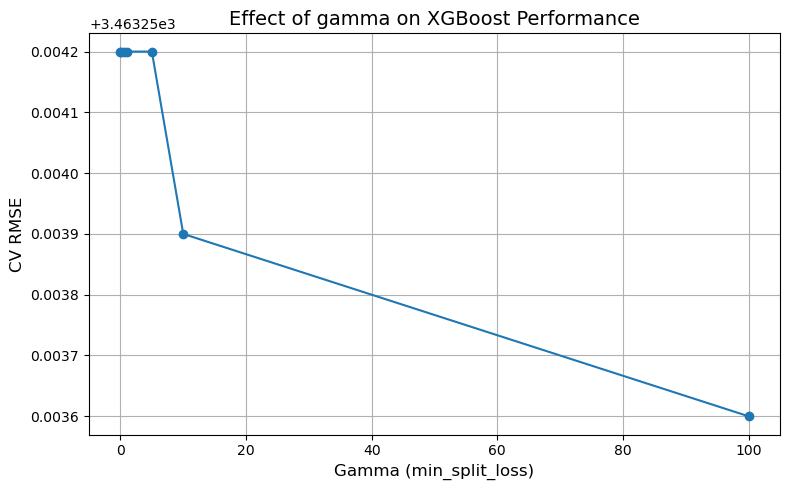

In [28]:
# Extract gamma values and corresponding mean CV RMSE
gamma_values = grid_search.cv_results_['param_regressor__gamma'].data

# Convert mean test scores to RMSE, rounding to 2 decimal places
mean_rmse_scores = np.sqrt(-grid_search.cv_results_['mean_test_score'])
# Round the RMSE scores to 2 decimal places
mean_rmse_scores = np.round(mean_rmse_scores, 4)

# Plot gamma vs RMSE with plain y-axis tick labels
plt.figure(figsize=(8, 5))
plt.plot(gamma_values, mean_rmse_scores, marker='o')
plt.xlabel('Gamma (min_split_loss)', fontsize=12)
plt.ylabel('CV RMSE', fontsize=12)
plt.title('Effect of gamma on XGBoost Performance', fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.show()


**Effect of `gamma` on XGBoost Performance**

As `gamma` increases, XGBoost becomes more selective about making splits.  
- **Low gamma (0–5)**: Trees grow freely → higher RMSE due to possible overfitting.
- **Moderate to high gamma (10–100)**: Blocks weak splits → simpler trees with better validation performance.

In this dataset, higher `gamma` values improved generalization by preventing unnecessary splits.

###  `reg_lambda` and `reg_alpha` in XGBoost

XGBoost includes **regularization** to help prevent overfitting by penalizing complex trees.

- `reg_lambda` (L2 regularization):
  - Penalizes large leaf weights using a squared penalty.
  - Encourages smaller, smoother weight values (like Ridge regression).
  - Helps when many features contribute weakly.

- `reg_alpha` (L1 regularization):
  - Penalizes absolute values of leaf weights.
  - Can shrink some weights to zero, effectively performing feature selection (like Lasso).
  - Useful when you expect only a few strong features.

**Objective function with regularization**:
$$
\mathcal{L} = \text{Loss} + \gamma T + \frac{1}{2} \lambda \sum_j w_j^2 + \alpha \sum_j |w_j|
$$

Where:
- $\text{Loss}$: training loss (e.g., squared error or log loss)
- $T$: number of leaves in the tree
- $w_j$: weight of the $j$-th leaf
- $\lambda$: L2 regularization (Ridge penalty)
- $\alpha$: L1 regularization (Lasso penalty)
- $\gamma$: cost for adding a new leaf (controls tree growth)

#### Understanding them via Ridge, Lasso, and ElasticNet you learned in STAT303-2

Just like Ridge/Lasso regularization helps linear models generalize better, `reg_lambda` and `reg_alpha` help XGBoost prevent overfitting by controlling how complex the trees become through leaf weight penalties.

- `reg_alpha` = 0 → **No L1 penalty**, behaves like Ridge (only L2 used)
- `reg_lambda` = 0 → **No L2 penalty**, behaves like Lasso (only L1 used)
- `reg_alpha > 0` and `reg_lambda > 0` → behaves like **ElasticNet**

This analogy helps understand how XGBoost controls model complexity:

| Setting                  | Behavior                                 |
|--------------------------|------------------------------------------|
| `reg_alpha=0`, `reg_lambda>0` | Like **Ridge** → smooth leaf weights, all included |
| `reg_alpha>0`, `reg_lambda=0` | Like **Lasso** → some leaf weights may shrink to zero |
| Both > 0                 | Like **ElasticNet** → balance shrinkage and sparsity |
| Both = 0 (default)       | No regularization → may overfit on small/noisy data |

In [29]:
# ===== 3. Regularization Experiments: tuning reg_lambda and reg_alpha =====
print("\n===== Exploring Regularization Parameters: reg_lambda and reg_alpha =====")

# Define the parameter grid for reg_lambda and reg_alpha
param_grid_reg = {
    'regressor__reg_lambda': [0, 0.1, 0.5, 1, 5, 10, 100],
    'regressor__reg_alpha': [0, 0.1, 0.5, 1, 5, 10, 100],
}

# Create a new pipeline for the regularization experiment
regularization_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, n_estimators=early_stop_model.best_iteration))
])

# Perform grid search with cross-validation
grid_search_reg = GridSearchCV(
    regularization_pipeline,
    param_grid_reg,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search_reg.fit(X_train, y_train)
print("\nBest Parameters from Regularization Experiment:")
print(grid_search_reg.best_params_)

print("Best Cross-Validation RMSE: {:.2f}".format(np.sqrt(-grid_search_reg.best_score_)))
# Evaluate the best model from grid search
best_model_reg = grid_search_reg.best_estimator_
print("\nRegularization Model Evaluation:")
regularization_metrics_reg = evaluate_model(best_model_reg, X_test, y_test)


===== Exploring Regularization Parameters: reg_lambda and reg_alpha =====

Best Parameters from Regularization Experiment:
{'regressor__reg_alpha': 1, 'regressor__reg_lambda': 0}
Best Cross-Validation RMSE: 3372.28

Regularization Model Evaluation:
Root Mean Squared Error: 3419.93
R² Score: 0.9601


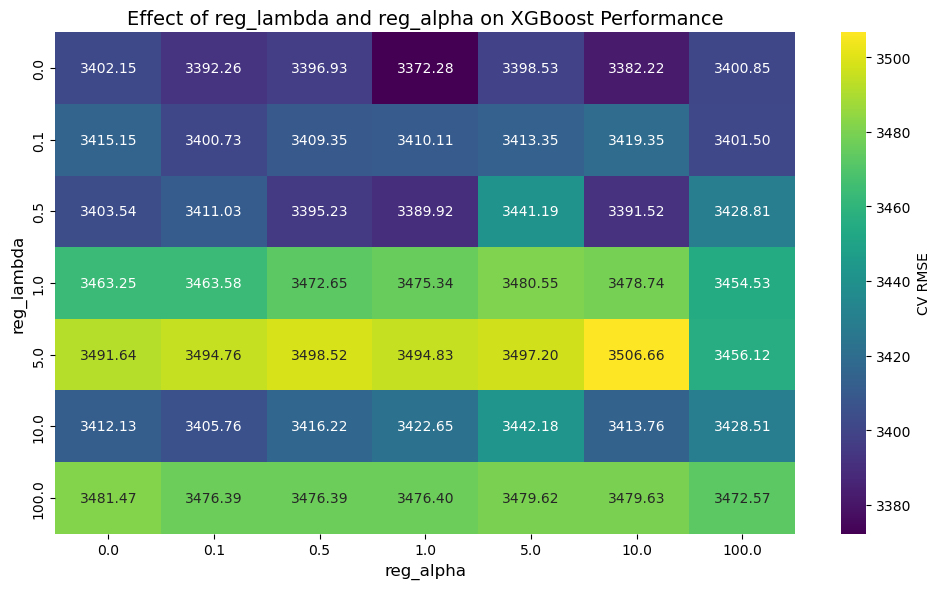

In [32]:
# Extract reg_lambda and reg_alpha values and corresponding mean CV RMSE
reg_lambda_values = grid_search_reg.cv_results_['param_regressor__reg_lambda'].data
reg_alpha_values = grid_search_reg.cv_results_['param_regressor__reg_alpha'].data

# Convert mean test scores to RMSE, rounding to 2 decimal places
mean_rmse_scores_reg = np.sqrt(-grid_search_reg.cv_results_['mean_test_score'])
# Round the RMSE scores to 2 decimal places
mean_rmse_scores_reg = np.round(mean_rmse_scores_reg, 4)

# Create a DataFrame for easier plotting
reg_results_df = pd.DataFrame({
    'reg_lambda': reg_lambda_values,
    'reg_alpha': reg_alpha_values,
    'mean_rmse': mean_rmse_scores_reg
})

# Pivot the DataFrame for heatmap
reg_pivot_df = reg_results_df.pivot(index='reg_lambda', columns='reg_alpha', values='mean_rmse')

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(reg_pivot_df, annot=True, fmt=".2f", cmap='viridis', cbar_kws={'label': 'CV RMSE'})
plt.title('Effect of reg_lambda and reg_alpha on XGBoost Performance', fontsize=14)
plt.xlabel('reg_alpha', fontsize=12)
plt.ylabel('reg_lambda', fontsize=12)
plt.tight_layout();

### Exploring Regularization Parameters Simultaneously

In addition to `gamma`, `reg_lambda`, and `reg_alpha`, the parameters `max_depth` and `min_child_weight` also control the complexity of XGBoost models. These parameters behave similarly to how they work in other tree-based models.

Rather than tuning them in isolation, it’s important to recognize that these parameters **interact** with one another. In the next step, we will tune them **simultaneously** to better capture their combined effect on model performance.


In [38]:

# ===== 3. Regularization Experiments =====
print("\n===== Exploring Regularization Parameters =====")
# Define regularization parameters to test
reg_params = [
    {'regressor__max_depth': 3, 'regressor__min_child_weight': 1, 'regressor__gamma': 0, 
     'regressor__reg_alpha': 0, 'regressor__reg_lambda': 1},
    {'regressor__max_depth': 3, 'regressor__min_child_weight': 1, 'regressor__gamma': 0, 
     'regressor__reg_alpha': 1, 'regressor__reg_lambda': 1},
    {'regressor__max_depth': 5, 'regressor__min_child_weight': 3, 'regressor__gamma': 0.1, 
     'regressor__reg_alpha': 0, 'regressor__reg_lambda': 1},
    {'regressor__max_depth': 5, 'regressor__min_child_weight': 3, 'regressor__gamma': 0.1, 
     'regressor__reg_alpha': 1, 'regressor__reg_lambda': 5},
    {'regressor__max_depth': 7, 'regressor__min_child_weight': 1, 'regressor__gamma': 0.2, 
     'regressor__reg_alpha': 5, 'regressor__reg_lambda': 10}
]

# Store results for comparison
reg_results = []

for i, params in enumerate(reg_params):
    print(f"\nRegularization Test {i+1}:")
    print(params)
    
    # Create pipeline with these parameters
    reg_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(
            random_state=42,
            n_estimators=early_stop_model.best_iteration,
            **{k.replace('regressor__', ''): v for k, v in params.items()}
        ))
    ])
    
    # Train and evaluate
    reg_pipeline.fit(X_train, y_train)
    print("\nModel Evaluation:")
    metrics = evaluate_model(reg_pipeline, X_test, y_test)
    rmse, r2 = metrics

    # Store results
    reg_results.append({
        'test': i+1,
        'params': params,
        'rmse': rmse,
        'r2': r2
    })

# Find best regularization parameters
reg_df = pd.DataFrame(reg_results)
best_reg_idx = reg_df['rmse'].idxmin()
best_reg_params = reg_df.loc[best_reg_idx, 'params']
print("\nBest Regularization Parameters:")
print(best_reg_params)
print("Best RMSE: {:.2f}".format(reg_df['rmse'].min()))


===== Exploring Regularization Parameters =====

Regularization Test 1:
{'regressor__max_depth': 3, 'regressor__min_child_weight': 1, 'regressor__gamma': 0, 'regressor__reg_alpha': 0, 'regressor__reg_lambda': 1}

Model Evaluation:
Root Mean Squared Error: 3884.82
R² Score: 0.9486

Regularization Test 2:
{'regressor__max_depth': 3, 'regressor__min_child_weight': 1, 'regressor__gamma': 0, 'regressor__reg_alpha': 1, 'regressor__reg_lambda': 1}

Model Evaluation:
Root Mean Squared Error: 3884.82
R² Score: 0.9486

Regularization Test 3:
{'regressor__max_depth': 5, 'regressor__min_child_weight': 3, 'regressor__gamma': 0.1, 'regressor__reg_alpha': 0, 'regressor__reg_lambda': 1}

Model Evaluation:
Root Mean Squared Error: 3342.40
R² Score: 0.9619

Regularization Test 4:
{'regressor__max_depth': 5, 'regressor__min_child_weight': 3, 'regressor__gamma': 0.1, 'regressor__reg_alpha': 1, 'regressor__reg_lambda': 5}

Model Evaluation:
Root Mean Squared Error: 3388.26
R² Score: 0.9609

Regularization

### Comprehensive Hyperparameter Tuning

#### `GridSearchCV`

In [54]:
# ===== 4. Comprehensive Hyperparameter Tuning =====
print("\n===== Comprehensive Hyperparameter Tuning =====")
# Define hyperparameter grid
param_grid = {
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 5, 7],
    'regressor__min_child_weight': [1, 3, 5],
    'regressor__gamma': [0, 0.1, 0.2],
    'regressor__subsample': [0.8, 0.9, 1.0],
    'regressor__colsample_bytree': [0.8, 0.9, 1.0],
    'regressor__reg_alpha': [0, 1, 5],
    'regressor__reg_lambda': [1, 5, 10]
}

# Create a pipeline for grid search
tune_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        random_state=42,
        n_estimators=early_stop_model.best_iteration
    ))
])

# Set up grid search with cross-validation
grid_search = GridSearchCV(
    tune_pipeline,
    param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# uncomment the line below to run the grid search (it may take a long time)
#grid_search.fit(X_train, y_train)


===== Comprehensive Hyperparameter Tuning =====


Instead of using `GridSearchCV`, let's use **Optuna** or **BayesSearchCV** to perform smarter hyperparameter optimization using Bayesian methods, which can converge to better results with fewer evaluations.

In [40]:
# define the search space for Bayesian optimization

search_space = {
    'regressor__learning_rate': Real(0.01, 0.5, prior='uniform'),
    'regressor__max_depth': Integer(3, 7),
    'regressor__min_child_weight': Integer(1, 5),
    'regressor__gamma': Real(0, 0.2),
    'regressor__subsample': Real(0.5, 1.0),
    'regressor__colsample_bytree': Real(0.5, 1.0),
    'regressor__reg_alpha': Real(0, 5),
    'regressor__reg_lambda': Real(1, 10)
}

# Create a pipeline for Bayesian optimization
bayes_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        random_state=42,
        n_estimators=early_stop_model.best_iteration
    ))
])
# Set up Bayesian optimization with cross-validation
bayes_search = BayesSearchCV(
    bayes_pipeline,
    search_space,
    n_iter=50,  # Number of iterations for Bayesian optimization
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
# Perform Bayesian optimization
bayes_search.fit(X_train, y_train)

# Print the best parameters and score
print("\nBest Parameters from Bayesian Optimization:")
print(bayes_search.best_params_)
print("Best Cross-Validation RMSE: {:.2f}".format(-bayes_search.best_score_))
# Evaluate the best model from Bayesian optimization
best_bayes_model = bayes_search.best_estimator_
print("\nBayesian Optimization Model Evaluation:")
bayes_metrics = evaluate_model(best_bayes_model, X_test, y_test)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [47]:
# Create the final model with the best parameters
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        random_state=42,
        n_estimators=early_stop_model.best_iteration,
        **{k.replace('regressor__', ''): v for k, v in bayes_search.best_params_.items()}
    ))
])

# Train the final model
final_pipeline.fit(X_train, y_train)

# Evaluate final model
print("\nFinal Model Evaluation:")
final_metrics = evaluate_model(final_pipeline, X_test, y_test)


Final Model Evaluation:
Root Mean Squared Error: 3171.68
R² Score: 0.9657


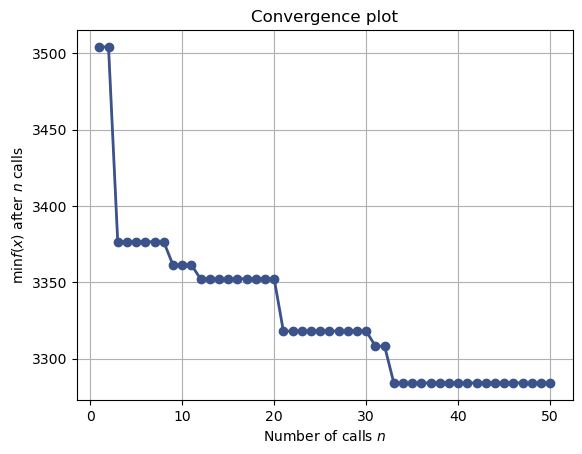

In [43]:
# plot convergence
plot_convergence(bayes_search.optimizer_results_);

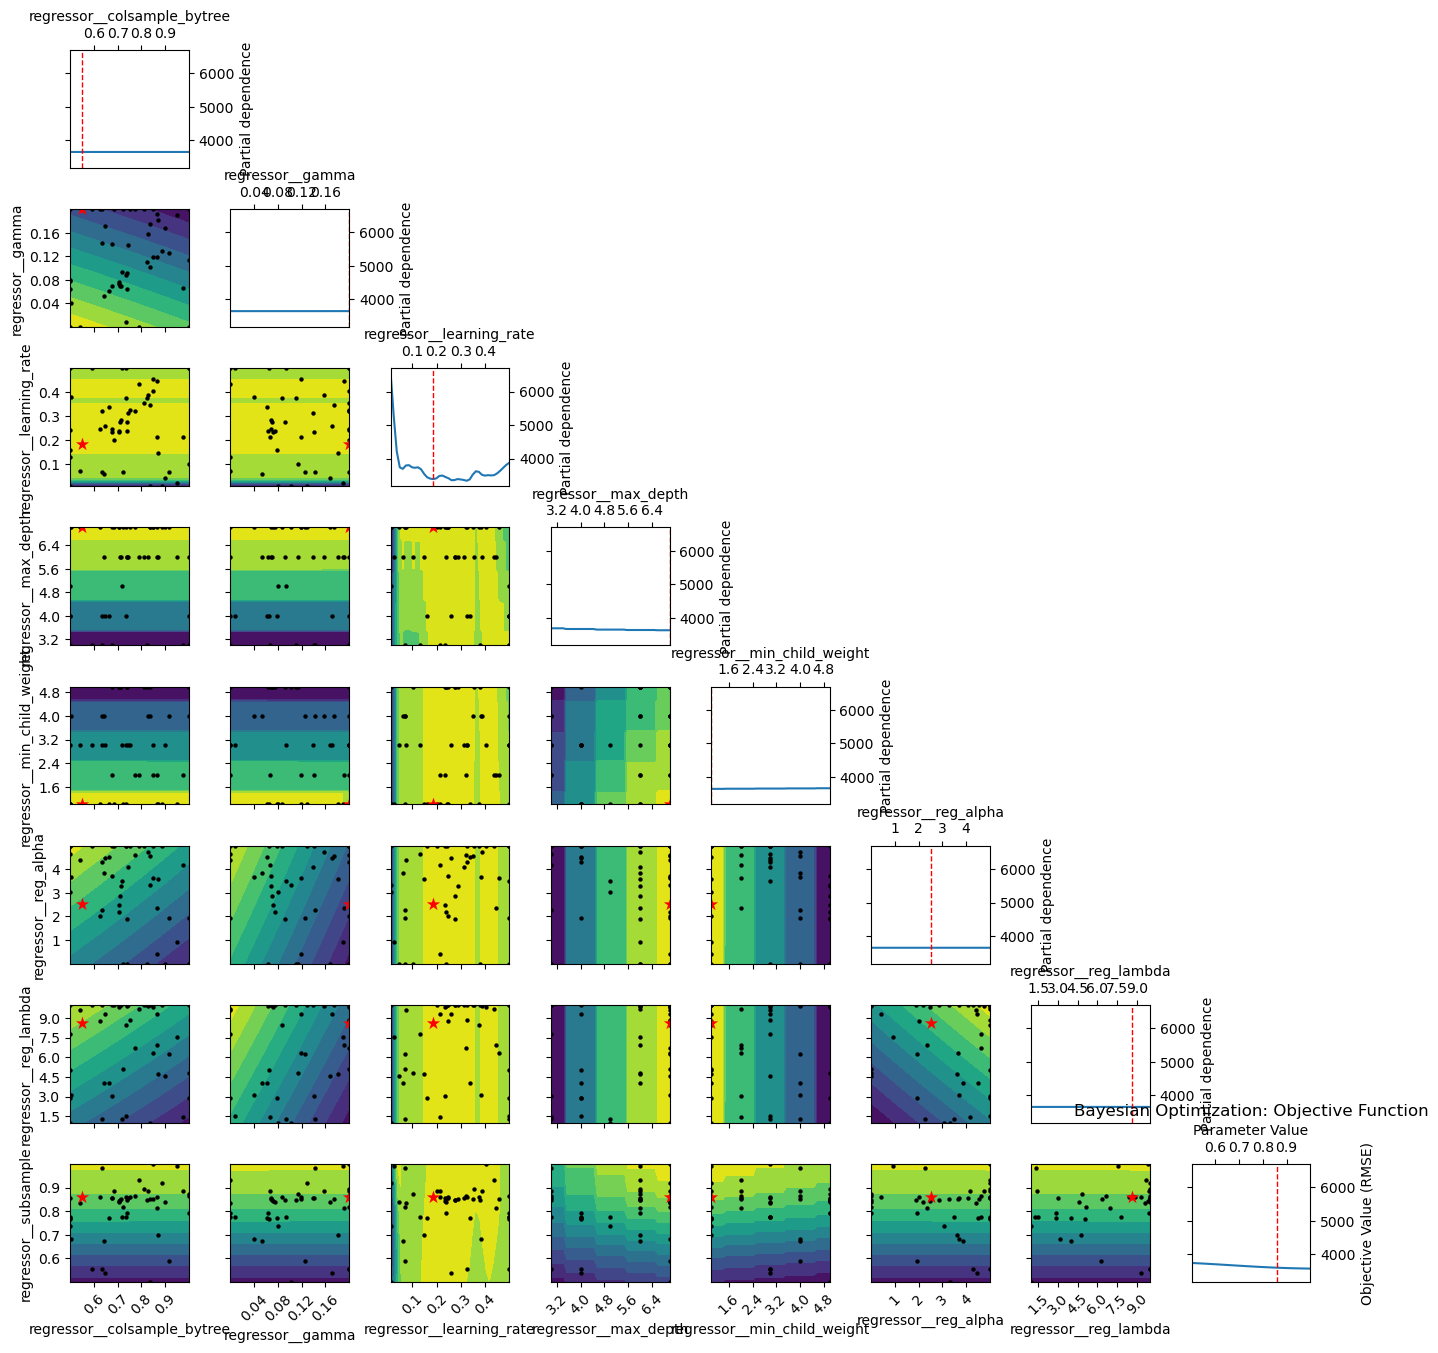

In [45]:
# Plot the objective function
plot_objective(bayes_search.optimizer_results_[0])
plt.title('Bayesian Optimization: Objective Function')
plt.xlabel('Parameter Value')
plt.ylabel('Objective Value (RMSE)')
plt.show()

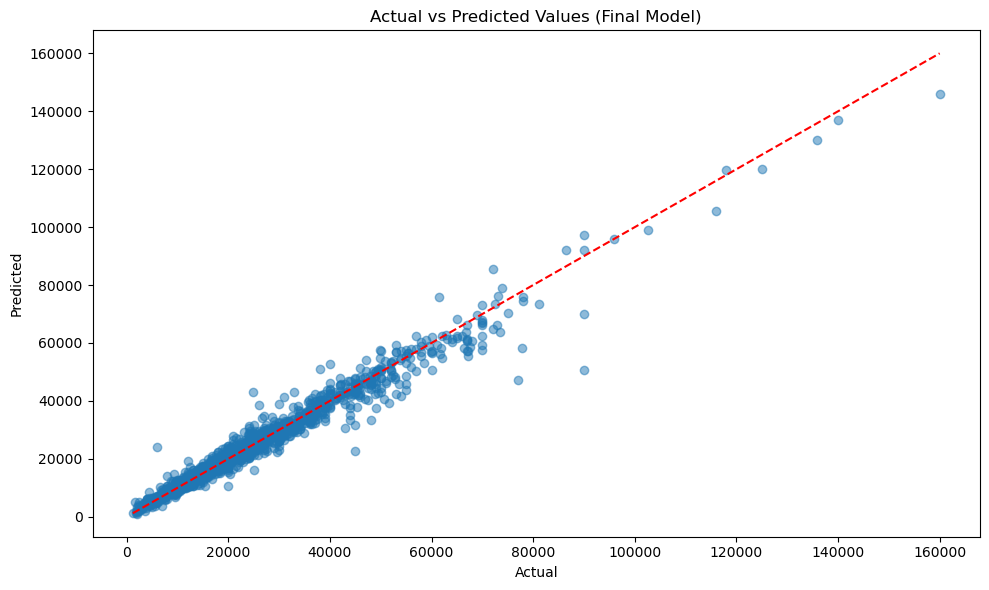

In [53]:
# Display actual vs predicted values for the final model
y_pred = final_pipeline.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values (Final Model)')
plt.tight_layout()
plt.show()

In [64]:
# output the feature importance for the final model
final_importance = plot_feature_importance(final_pipeline.named_steps['regressor'], 
                                             final_pipeline.named_steps['preprocessor'], 
                                             X)
final_importance

,Feature,Importance
0,engineSize,0.077682
1,model_ I800,0.076378
2,transmission_Manual,0.064949
3,brand_ford,0.062391
4,model_ S Class,0.043893
5,brand_vw,0.041013
6,model_ Hilux,0.039502
7,brand_hyundi,0.035647
8,brand_bmw,0.033629
9,model_ X7,0.031765


## XGBoost for classification

###  Handling Class Imbalance with `scale_pos_weight`

In binary classification tasks, when one class is much rarer than the other (e.g., fraud detection, disease diagnosis), XGBoost models can become biased toward the majority class.

To address this, XGBoost provides the `scale_pos_weight` parameter:


###  What it does

`scale_pos_weight` changes the **relative importance** of positive examples during training by multiplying the gradients and Hessians of the **positive class** (label = 1).

- A higher value **increases the penalty** for misclassifying positive samples.
- This encourages the model to focus more on correctly predicting rare (positive) cases.



###  When to use it

Use `scale_pos_weight > 1` when:

- Your data is **heavily imbalanced**, and
- You want to improve **recall** or **F1-score** on the minority (positive) class.



###  How to set it

A common heuristic:

$$
\text{scale\_pos\_weight} = \frac{\text{number of negative samples}}{\text{number of positive samples}}
$$

This helps the model give more attention to the minority (positive) class by scaling its gradient and Hessian contributions during training.

Use this as a **starting point**, and then fine-tune through cross-validation for best performance.

In [61]:
diabetes_train = pd.read_csv('./Datasets/diabetes_train.csv')
diabetes_test = pd.read_csv('./Datasets/diabetes_test.csv')

In [62]:
print(diabetes_train.shape, diabetes_test.shape)
diabetes_train.head()

(614, 9) (154, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,88,74,19,53,29.0,0.229,22,0
1,2,129,84,0,0,28.0,0.284,27,0
2,0,102,78,40,90,34.5,0.238,24,0
3,0,123,72,0,0,36.3,0.258,52,1
4,1,144,82,46,180,46.1,0.335,46,1


In [63]:
# check the outcome of the distribution in the training set and test set
print(diabetes_train['Outcome'].value_counts(normalize=True))
print(diabetes_test['Outcome'].value_counts(normalize=True))

Outcome
0    0.662866
1    0.337134
Name: proportion, dtype: float64
Outcome
0    0.603896
1    0.396104
Name: proportion, dtype: float64


In [ ]:
# Data Preprocessing
X_diabetes = diabetes_train.drop(columns=['Outcome'])
y_diabetes = diabetes_train['Outcome']
X_diabetes_test = diabetes_test.drop(columns=['Outcome'])
y_diabetes_test = diabetes_test['Outcome']

# define categorical and numerical columns
categorical_cols_diabetes = X_diabetes.select_dtypes(include=['object']).columns.tolist()
numerical_cols_diabetes = X_diabetes.select_dtypes(exclude=['object']).columns.tolist()

# define the preprocessor, passing the numerical and categorical columns
preprocessor_diabetes = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols_diabetes),  # no scaling
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_diabetes)
    ]
)

# Create a pipeline for the diabetes dataset
diabetes_pipeline = Pipeline([
    ('preprocessor', preprocessor_diabetes),
    ('regressor', XGBClassifier(random_state=42))
])

# Train the pipeline on the diabetes dataset
diabetes_pipeline.fit(X_diabetes, y_diabetes)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Pregnancies', 'Glucose',
                                                   'BloodPressure',
                                                   'SkinThickness', 'Insulin',
                                                   'BMI',
                                                   'DiabetesPedigreeFunction',
                                                   'Age']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('regressor',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [69]:
# make predictions on the test set

print("\n===== Test Performance with Default Setting =====")
y_diabetes_pred = diabetes_pipeline.predict(X_diabetes_test)
# evaluate the model in terms of accuracy, precision, recall, and f1-score
accuracy = np.mean(y_diabetes_pred == y_diabetes_test)
print(f"Accuracy on Diabetes Test Set: {accuracy:.2f}")
precision = precision_score(y_diabetes_test, y_diabetes_pred)
print(f"Precision on Diabetes Test Set: {precision:.2f}")
recall = recall_score(y_diabetes_test, y_diabetes_pred)
print(f"Recall on Diabetes Test Set: {recall:.2f}")
f1 = f1_score(y_diabetes_test, y_diabetes_pred)
print(f"F1 Score on Diabetes Test Set: {f1:.2f}")


===== Test Performance with Default Setting =====
Accuracy on Diabetes Test Set: 0.73
Precision on Diabetes Test Set: 0.68
Recall on Diabetes Test Set: 0.59
F1 Score on Diabetes Test Set: 0.63


### Using `scale_pos_weight `

In [ ]:
neg = (diabetes_train['Outcome'] == 0).sum()
pos = (diabetes_train['Outcome'] == 1).sum()
baseline_ratio = neg / pos

# set a small grid for scale_pos_weight
scale_pos_weight = [1, 2, 3, 5, 10]

# Create a new pipeline for the diabetes dataset
diabetes_pipeline_scale = Pipeline([
    ('preprocessor', preprocessor_diabetes),
    ('regressor', XGBClassifier(random_state=42))
])

# Store results for comparison
diabetes_results = []
for i, weight in enumerate(scale_pos_weight):
    print(f"\nScale Pos Weight Test {i+1}:")
    print(f"scale_pos_weight = {weight}")
    
    # Update the pipeline with the scale_pos_weight parameter
    diabetes_pipeline_scale.set_params(regressor__scale_pos_weight=weight)
    
    # Train and evaluate
    diabetes_pipeline_scale.fit(X_diabetes, y_diabetes)
    y_diabetes_pred = diabetes_pipeline_scale.predict(X_diabetes_test)
    
    # Evaluate the model
    accuracy = np.mean(y_diabetes_pred == y_diabetes_test)
    precision = precision_score(y_diabetes_test, y_diabetes_pred)
    recall = recall_score(y_diabetes_test, y_diabetes_pred)
    f1 = f1_score(y_diabetes_test, y_diabetes_pred)
    
    # Store results
    diabetes_results.append({
        'test': i+1,
        'scale_pos_weight': weight,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })
# Create a DataFrame for the results
diabetes_results_df = pd.DataFrame(diabetes_results)   

# Find the best scale_pos_weight based on F1 score
best_f1_idx = diabetes_results_df['f1'].idxmax()
best_scale_pos_weight = diabetes_results_df.loc[best_f1_idx, 'scale_pos_weight']
print("\n===== Test Performance with Best Scale Pos Weight: =====")
print(best_scale_pos_weight)
print("Best F1 Score: {:.2f}".format(diabetes_results_df['f1'].max()))
# find the accuracy, precision, and recall for the best scale_pos_weight
best_accuracy = diabetes_results_df.loc[best_f1_idx, 'accuracy']
best_precision = diabetes_results_df.loc[best_f1_idx, 'precision']
best_recall = diabetes_results_df.loc[best_f1_idx, 'recall']
print(f"Best Accuracy: {best_accuracy:.2f}")
print(f"Best Precision: {best_precision:.2f}")
print(f"Best Recall: {best_recall:.2f}")


Scale Pos Weight Test 1:
scale_pos_weight = 1

Scale Pos Weight Test 2:
scale_pos_weight = 2

Scale Pos Weight Test 3:
scale_pos_weight = 3

Scale Pos Weight Test 4:
scale_pos_weight = 5

Scale Pos Weight Test 5:
scale_pos_weight = 10

Best Scale Pos Weight:
3
Best F1 Score: 0.69
Best Accuracy: 0.76
Best Precision: 0.71
Best Recall: 0.67


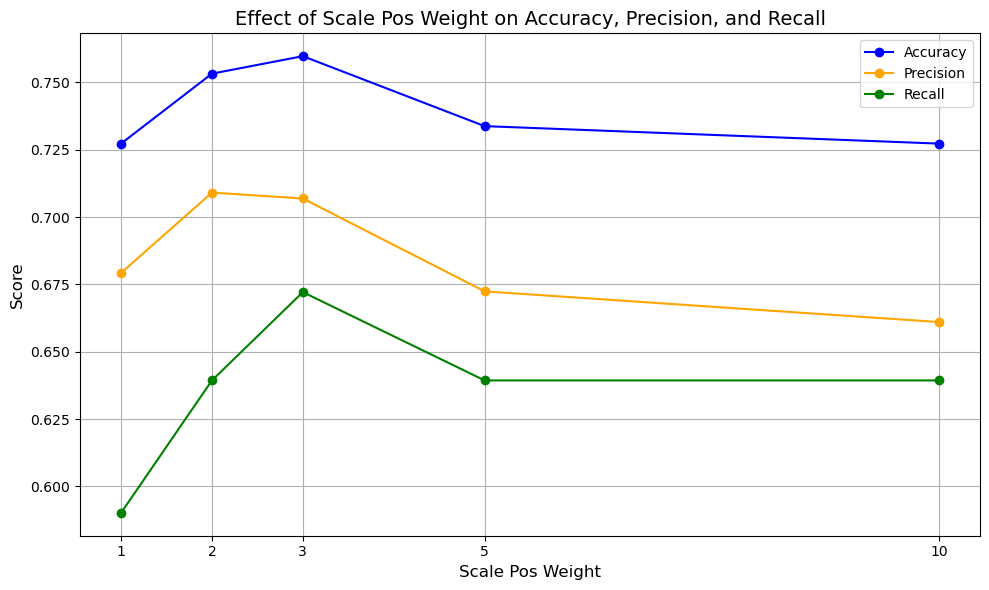

In [75]:
# Plot the results for accuracy, precision, and recall with different colors
plt.figure(figsize=(10, 6))
plt.plot(diabetes_results_df['scale_pos_weight'], diabetes_results_df['accuracy'], marker='o', color='blue', label='Accuracy')
plt.plot(diabetes_results_df['scale_pos_weight'], diabetes_results_df['precision'], marker='o', color='orange', label='Precision')
plt.plot(diabetes_results_df['scale_pos_weight'], diabetes_results_df['recall'], marker='o', color='green', label='Recall')
plt.xlabel('Scale Pos Weight', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Effect of Scale Pos Weight on Accuracy, Precision, and Recall', fontsize=14)
plt.grid(True)
plt.xticks(scale_pos_weight)
plt.legend()
plt.tight_layout()
plt.show()

Tuning `scale_pos_weight` changes the **model's internal learning dynamics**, not just the decision threshold. This allows the model to adjust how it learns from imbalanced data.


In this case, as `scale_pos_weight` increases from 1 to 3:

- XGBoost starts giving **more importance to the minority (positive) class**.
- The model becomes better at identifying **true positives** → ✅ **Recall increases**
- Simultaneously, it avoids more **false positives** → ✅ **Precision increases**


✅ This indicates the model was previously **underperforming on the positive class**, and that moderate rebalancing (e.g., `scale_pos_weight = 3`) helped improve **both recall and precision** — something that can happen when the model is initially biased toward the majority class.



### Threshold adjustment

Best Threshold for F1 Score: 0.19
Accuracy with Adjusted Threshold: 0.78
Precision with Adjusted Threshold: 0.68
Recall with Adjusted Threshold: 0.82


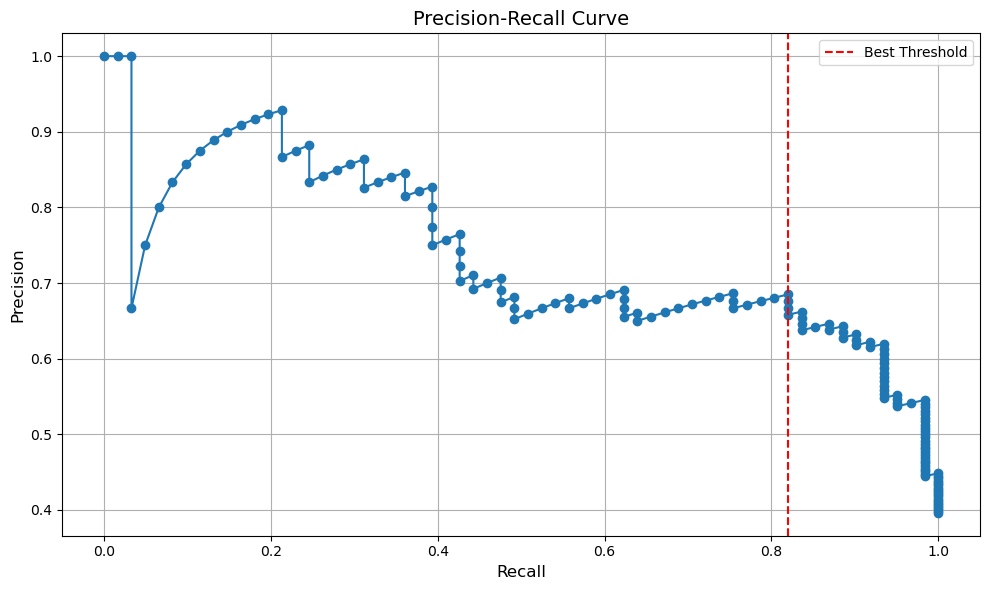

In [ ]:
# get prediction probabilities
y_diabetes_pred_proba = diabetes_pipeline.predict_proba(X_diabetes_test)[:, 1]

# plot the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_diabetes_test, y_diabetes_pred_proba)

# final threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9) # avoid division by zero
best_f1_threshold = thresholds[np.argmax(f1_scores)]
best_threshold = np.round(best_f1_threshold, 2)
print(f"Best Threshold for F1 Score: {best_threshold:.2f}")

# adjust the threshold for the predictions
y_diabetes_pred_adjusted = (y_diabetes_pred_proba >= best_f1_threshold).astype(int)
# evaluate the model with the adjusted threshold
accuracy_adjusted = np.mean(y_diabetes_pred_adjusted == y_diabetes_test)
print(f"Accuracy with Adjusted Threshold: {accuracy_adjusted:.2f}")
precision_adjusted = precision_score(y_diabetes_test, y_diabetes_pred_adjusted)
print(f"Precision with Adjusted Threshold: {precision_adjusted:.2f}")
recall_adjusted = recall_score(y_diabetes_test, y_diabetes_pred_adjusted)
print(f"Recall with Adjusted Threshold: {recall_adjusted:.2f}")
# plot the precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='o')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14)
plt.grid(True)
plt.axvline(x=recall[np.argmax(f1_scores)], color='red', linestyle='--', label='Best Threshold')
plt.legend()
plt.tight_layout()
plt.show()